<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Требуется:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


## Подготовка данных

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

rs = 42 # random_state

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


**Мы видим много столбцов с различными операциями и параметрами. Посмотрим некоторую информацию по трем таблицам:**

In [4]:
info = pd.DataFrame({'Количество столбцов':[len(full.columns), len(train.columns), len(test.columns)],
                     'пропуски':[full.isna().sum().sum(), train.isna().sum().sum(), test.isna().sum().sum()],
                     'количество строк':[full.value_counts().count(), train.value_counts().count(), test.value_counts().count()]
                   }).T
info.columns = ['full', 'train', 'test']
info

,full,train,test
Количество столбцов,87,87,53
пропуски,4481,4100,90
количество строк,16094,11017,5229


**В тестовой выборке меньше столбцов и пропусков. Пропусков достаточно много в полной таблице и тренеровочной выборке**

In [5]:
test.value_counts().count()

5229

**Проверим правильность рассчета эффективности обогащения:**

In [6]:
def recovery(c, f, t):
    recovery = ((c*(f-t))/(f*(c-t))) * 100
    return recovery
ror = recovery(train['rougher.output.concentrate_au'], train['rougher.input.feed_au'], train['rougher.output.tail_au'])
mean_absolute_error(ror, train['rougher.output.recovery'])

9.73512347450521e-15

**Наличие средней абсолютной ошибки говорит о наличии ошибоки, но число настолько маленькое, что можно это не учитывать.
человеческий вид записи этого числа 9,74 * 10^(−15)**

**Выведем столбцы, которые отсутствуют в тестовой выборке**

In [7]:
drop = train.drop(test.columns, axis = 1).columns.to_list()
drop

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

**В тестовой выборке срезаны столбцы с параметрами выходящего продукта на всех стадиях и некоторые рассчетные характеристики**

**Посмотрим, что из себя представляют таблицы:**

In [8]:
train.head(2)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184


In [9]:
full.head(2)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184


In [10]:
test.head(2)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.08,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438


**Приведем столбец date в соответствующий тип**

In [11]:
def datetimefunc(df):
    df['date'] = pd.to_datetime(df['date'], format = "%Y-%m-%dT%H:%M:%S")
    return df
for i in [test, full, train]:
    i = datetimefunc(i)

**Поставим в индекс время.**

In [12]:
def reindex(df):
    df.index = df['date']
    df = df.drop('date', axis = 1)
    return df
test = reindex(test)
full = reindex(full)
train = reindex(train)

**Заполним пропуски предыдущими значениями, удалив строки с пропущенным целевым признаком**

In [13]:
full = full.dropna(subset = ['rougher.output.recovery', 'final.output.recovery']).ffill()
train = train.dropna(subset = ['rougher.output.recovery', 'final.output.recovery']).ffill()
test = test.ffill()

## Анализ данных

**Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки:**

**Среднее значение**

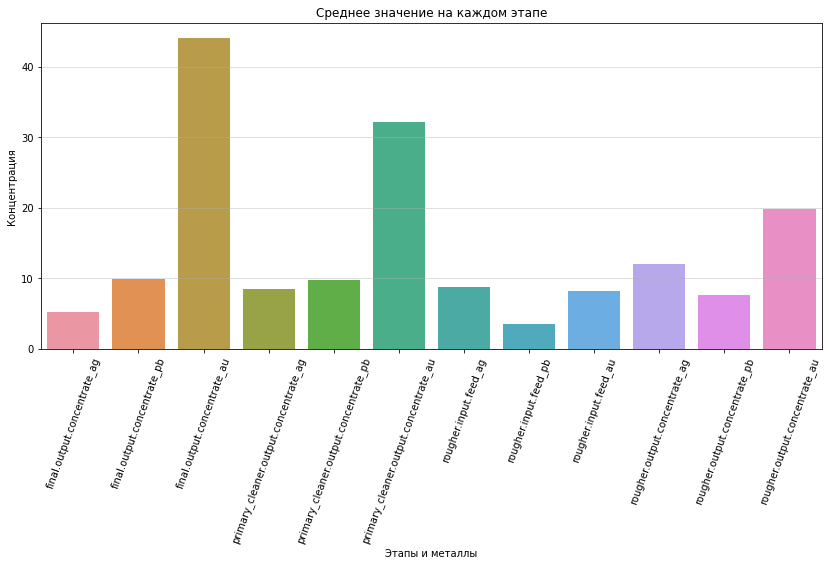

In [14]:
p = []
for i in full.columns:
    if i.__contains__('feed_au') or i.__contains__('feed_ag') or i.__contains__('feed_pb')or i.__contains__('concentrate_au') or i.__contains__('concentrate_ag') or i.__contains__('concentrate_pb'):
        p.append(i)        
hist_au_ag_pb = pd.DataFrame(full.loc[:, p].mean()).reset_index()
hist_au_ag_pb.columns = ['x', 'y']
plt.figure(figsize=(14, 6))
sns.barplot(data = hist_au_ag_pb, y = 'y', x = 'x')
plt.xticks(rotation=70)
plt.grid(axis = 'y', alpha = 0.5)
plt.xlabel('Этапы и металлы')
plt.ylabel('Концентрация')
plt.title('Среднее значение на каждом этапе')
plt.show()

**Концентрация au поэтапно увеличивается, концентрация pb в среднем намного меньше, но так же поэтапно увеличивается, концентрация ag снижается** 

**Посмотрим распределение:**

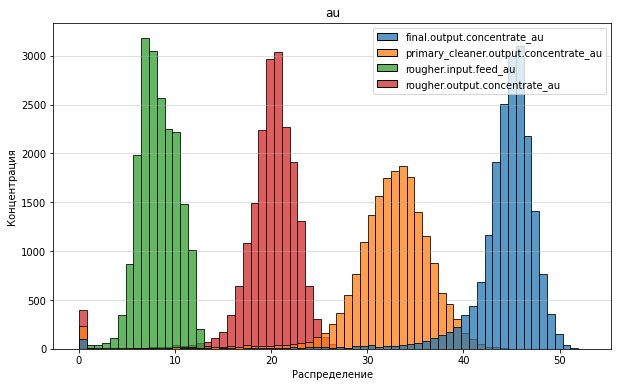

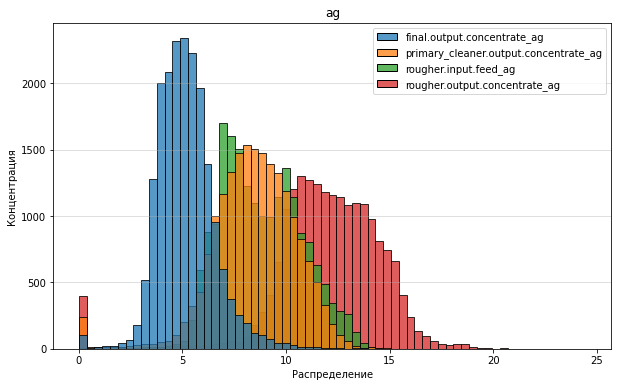

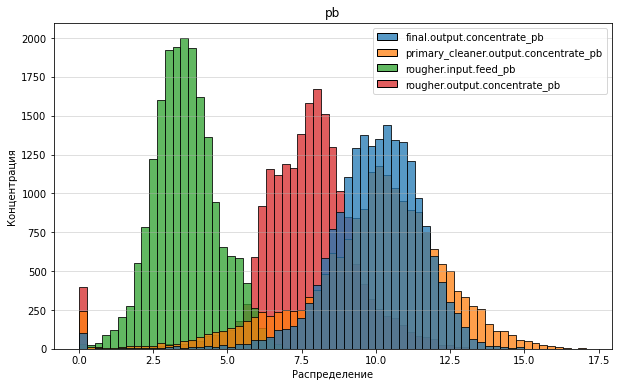

In [15]:
pupu = []
for i in full.columns:
    if i.__contains__('feed_au') or i.__contains__('feed_ag') or i.__contains__('feed_pb')or i.__contains__('concentrate_au') or i.__contains__('concentrate_ag') or i.__contains__('concentrate_pb'):
        pupu.append(i)
popo = full[pupu]        
for pipi in ['au', 'ag', 'pb']:
    pepe  = []
    for i in popo.columns:
        if i.__contains__(pipi):
            pepe.append(i)        
    
    plt.figure(figsize=(10, 6))
    sns.histplot(full.loc[:, pepe], bins = 65)
    plt.grid(axis = 'y', alpha = 0.5)
    plt.xlabel('Распределение')
    plt.ylabel('Концентрация')
    plt.title(pipi)
    plt.show()

**На графике можно увидеть, что концентрация золота поэтапно увеличивается:**
1. rougher.input.feed_au - в среднем 8
2. rougher.output.feed_au - в среднем 21
3. primary_cleaner.output.concentrate_au - в среднем 32
4. final.output.concentrate_au - в среднем 43

**Мы видим, что есть некоторое количество нулевых значений. Для повышения качества модели удалим их:**

In [16]:
for pp in p:
    train = train.loc[train[pp] > 1]
for pp in p:
    full = full.loc[full[pp] > 1]
print('Минимальные значения:')    
for df in [train, full]:
    for pp in p:
        print(str(pp), ' - ', df[pp].min())

Минимальные значения:
final.output.concentrate_ag  -  1.0084698264775216
final.output.concentrate_pb  -  1.8127683739364149
final.output.concentrate_au  -  1.482979107612286
primary_cleaner.output.concentrate_ag  -  1.0123948414119233
primary_cleaner.output.concentrate_pb  -  1.2359782836411748
primary_cleaner.output.concentrate_au  -  2.9912558990821063
rougher.input.feed_ag  -  2.2156882574568586
rougher.input.feed_pb  -  1.006167786773294
rougher.input.feed_au  -  1.025235159676522
rougher.output.concentrate_ag  -  2.1538265870137634
rougher.output.concentrate_pb  -  1.3496411574093832
rougher.output.concentrate_au  -  3.066083780475043
final.output.concentrate_ag  -  1.0084698264775216
final.output.concentrate_pb  -  1.6790355791110132
final.output.concentrate_au  -  1.482979107612286
primary_cleaner.output.concentrate_ag  -  1.0123948414119233
primary_cleaner.output.concentrate_pb  -  1.2359782836411748
primary_cleaner.output.concentrate_au  -  2.9912558990821063
rougher.input.fee

**Сравним размеры гранул сырья на обучающей и тестовой выборках.**

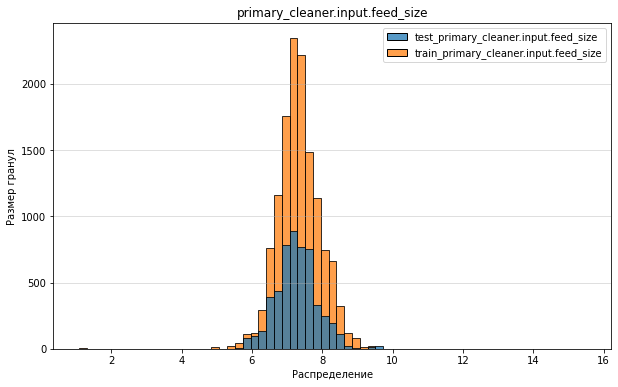

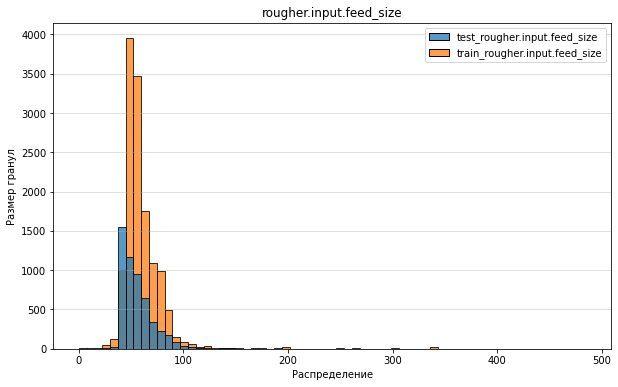

In [17]:
o = []
for i in test.columns:
    if i.__contains__('feed_size'):
        o.append(i)  
otest = test.loc[:, o]
otrain = train.loc[:, o]
hist_feed_size = pd.concat([otest, otrain], axis = 1)
hist_feed_size.columns = ['test_primary_cleaner.input.feed_size','test_rougher.input.feed_size',
                          'train_primary_cleaner.input.feed_size','train_rougher.input.feed_size']
for feed in ['primary_cleaner.input.feed_size','rougher.input.feed_size']:
    uwu = []
    for i in hist_feed_size.columns:
        if i.__contains__(feed):
            uwu.append(i)        
    
    plt.figure(figsize=(10, 6))
    sns.histplot(hist_feed_size.loc[:, uwu], bins = 65)
    plt.grid(axis = 'y', alpha = 0.5)
    plt.xlabel('Распределение')
    plt.ylabel('Размер гранул')
    plt.title(feed)
    plt.show() 

**Распределение не сильно отличается. На качестве модели это не скажется.**

**Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах**

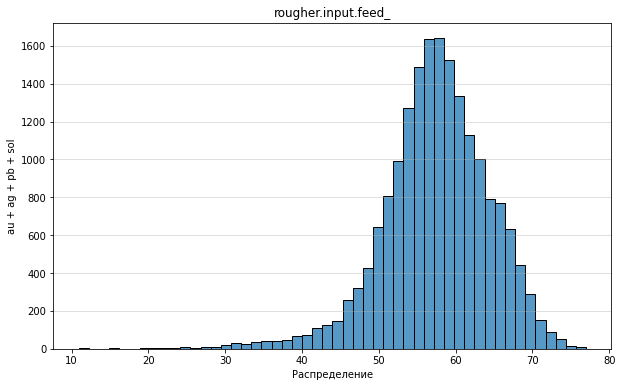

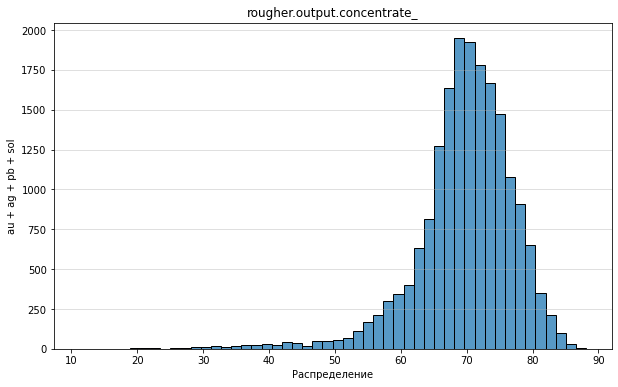

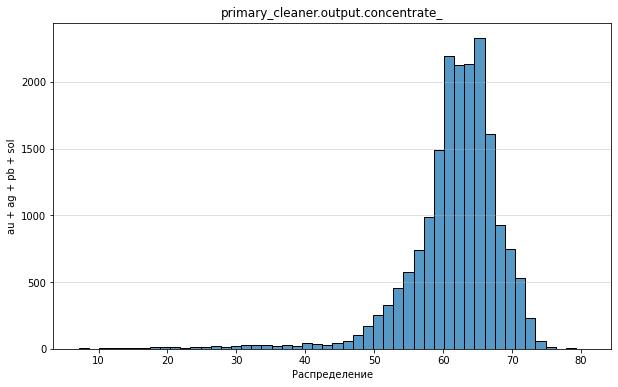

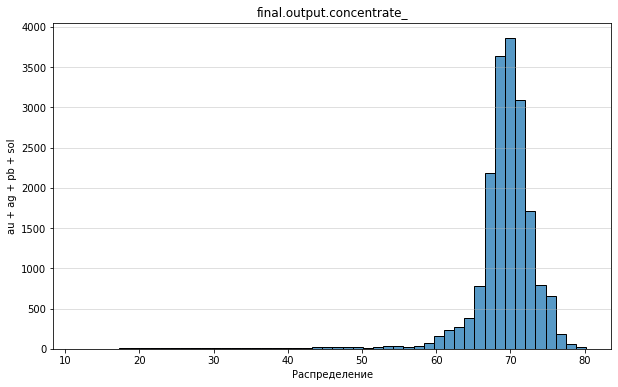

In [18]:
import warnings
warnings.filterwarnings("ignore")
iwi = []
for i in full.columns:
    if i.__contains__('feed_au') or i.__contains__('feed_ag') or i.__contains__('feed_pb')or i.__contains__('feed_sol') or i.__contains__('concentrate_'):
        iwi.append(i)        
summm = full[iwi]
for y in ['rougher.input.feed_', 'rougher.output.concentrate_', 'primary_cleaner.output.concentrate_', 'final.output.concentrate_']:
    uwu = []
    for i in iwi:
        if i.__contains__(y):
            uwu.append(i)
    summm['sum'] = summm[uwu[0]] + summm[uwu[1]] + summm[uwu[2]] + summm[uwu[3]]
    plt.figure(figsize=(10, 6))
    sns.histplot(summm['sum'], bins = 50)
    plt.grid(axis = 'y', alpha = 0.5)
    plt.xlabel('Распределение')
    plt.ylabel('au + ag + pb + sol')
    plt.title(y)
    plt.show() 

**У всех металлов суммарная концентрация на всех этапах постепенно растет. Здесь так же есть небольшое количество нулевых значений, которые стоит убрать**

In [19]:
for pp in iwi:
    train = train.loc[train[pp] > 1]
for pp in iwi:
    full = full.loc[full[pp] > 1]
print('Минимальные значения:')    
for df in [train, full]:
    for pp in iwi:
        print(str(pp), ' - ', df[pp].min())

Минимальные значения:
final.output.concentrate_ag  -  1.0084698264775216
final.output.concentrate_pb  -  1.8127683739364149
final.output.concentrate_sol  -  1.0166924284258858
final.output.concentrate_au  -  1.482979107612286
primary_cleaner.output.concentrate_ag  -  1.0123948414119233
primary_cleaner.output.concentrate_pb  -  1.2546373817986909
primary_cleaner.output.concentrate_sol  -  1.003160325292653
primary_cleaner.output.concentrate_au  -  2.9912558990821063
rougher.input.feed_ag  -  2.2156882574568586
rougher.input.feed_pb  -  1.006167786773294
rougher.input.feed_sol  -  3.1359269361940263
rougher.input.feed_au  -  1.025235159676522
rougher.output.concentrate_ag  -  2.1538265870137634
rougher.output.concentrate_pb  -  1.3496411574093832
rougher.output.concentrate_sol  -  1.7159061482191509
rougher.output.concentrate_au  -  3.066083780475043
final.output.concentrate_ag  -  1.0084698264775216
final.output.concentrate_pb  -  1.6790355791110132
final.output.concentrate_sol  -  1.01

## Модель

**Функции sMAPE  и final sMAPE**

In [20]:
def smape(target, predict):
    return 1/len(target) * np.sum(2 * np.abs(target - predict) / (np.abs(target) + np.abs(predict))*100)
def finalsmape(rougher, final):
    return 0.25*rougher + 0.75*final

**Подготовим выборки и проведем масштабирование признаков**

In [21]:
target_train_rou = train['rougher.output.recovery']
target_train_fin = train['final.output.recovery']
features_train = train.drop(drop, axis = 1)

scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)

In [22]:
scorer = make_scorer(smape, greater_is_better = False)

**Обучим разные модели и оценим результат кросс валидацией:**

**CatBoostRegressor**

In [23]:
modelcat = CatBoostRegressor(iterations=300, verbose=100, early_stopping_rounds=100, random_state = rs)
scores_cat_rou = cross_val_score(modelcat, features_train, target_train_rou, cv=5, scoring = scorer).mean()
scores_cat_fin = cross_val_score(modelcat, features_train, target_train_fin, cv=5, scoring = scorer).mean()
score_catboost = finalsmape(scores_cat_rou, scores_cat_fin)

Learning rate set to 0.158327
0:	learn: 6.5077352	total: 73ms	remaining: 21.8s
100:	learn: 2.6813504	total: 1.63s	remaining: 3.21s
200:	learn: 2.1396664	total: 3.26s	remaining: 1.6s
299:	learn: 1.8348968	total: 4.81s	remaining: 0us
Learning rate set to 0.158327
0:	learn: 7.0478004	total: 16.8ms	remaining: 5.02s
100:	learn: 2.9362721	total: 1.57s	remaining: 3.09s
200:	learn: 2.3451935	total: 3.14s	remaining: 1.54s
299:	learn: 2.0118985	total: 4.65s	remaining: 0us
Learning rate set to 0.158327
0:	learn: 7.5467941	total: 16.1ms	remaining: 4.82s
100:	learn: 3.0857167	total: 1.51s	remaining: 2.97s
200:	learn: 2.4440851	total: 3.07s	remaining: 1.51s
299:	learn: 2.0977137	total: 4.64s	remaining: 0us
Learning rate set to 0.158327
0:	learn: 7.3160757	total: 24.5ms	remaining: 7.34s
100:	learn: 3.0500100	total: 1.68s	remaining: 3.32s
200:	learn: 2.4261916	total: 3.23s	remaining: 1.59s
299:	learn: 2.0592397	total: 4.65s	remaining: 0us
Learning rate set to 0.15833
0:	learn: 7.0830342	total: 15.8ms	

In [24]:
score_catboost

-8.498200502392626

**DecisionTreeRegressor**

In [58]:
best_max_depth = 0
best_scores_dtr_rou = 0
best_scores_dtr_fin = 0
best_smape = 100
for md in (1, 35, 2):
    modeldtr = DecisionTreeRegressor(random_state = rs, max_depth = md)
    scores_dtr_rou = cross_val_score(modeldtr, features_train, target_train_rou, cv=5, scoring = scorer).mean()
    scores_dtr_fin = cross_val_score(modeldtr, features_train, target_train_fin, cv=5, scoring = scorer).mean()
    score_dtr = finalsmape(scores_dtr_rou, scores_dtr_fin)
    if score_dtr < best_smape:
        best_smape = score_dtr
        best_max_depth = md
        best_scores_dtr_rou = scores_dtr_rou
        best_scores_dtr_fin = scores_dtr_fin

In [60]:
print(best_smape)
print(best_max_depth)
print(best_scores_dtr_rou)
print(best_scores_dtr_fin)

-13.239362943331042
35
-8.448663158623905
-14.836262871566754


**RandomForestRegressor**

In [27]:
modelrfr = RandomForestRegressor(random_state = rs, n_estimators = 150, max_features = 20)
scores_rfr_rou = cross_val_score(modelrfr, features_train, target_train_rou, cv=5, scoring = scorer).mean()
scores_rfr_fin = cross_val_score(modelrfr, features_train, target_train_fin, cv=5, scoring = scorer).mean()
score_rfr = finalsmape(scores_rfr_rou, scores_rfr_fin)

In [30]:
score_rfr

-8.40049723183771

**LinearRegression**

In [31]:
modellr = LinearRegression()
scores_lr_rou = cross_val_score(modellr, features_train, target_train_rou, cv=5, scoring = scorer).mean()
scores_lr_fin = cross_val_score(modellr, features_train, target_train_fin, cv=5, scoring = scorer).mean()
score_lr = finalsmape(scores_lr_rou, scores_lr_fin)

In [32]:
score_lr

-9.827867845267427

**Что мы получили:**

In [61]:
tab = pd.DataFrame({'sMAPE rougher' : [scores_cat_rou, best_scores_dtr_rou, scores_rfr_rou, scores_lr_rou],
             'sMAPE final': [scores_cat_fin, best_scores_dtr_fin, scores_rfr_fin, scores_lr_fin],
             'Итоговое sMAPE': [score_catboost, best_smape, score_rfr, score_lr]})
tab.index = ['CatBoost', 'DecisionTree', 'RandomForest', 'LinearRegression']
tab

,sMAPE rougher,sMAPE final,Итоговое sMAPE
CatBoost,-6.189250,-9.267851,-8.498201
DecisionTree,-8.448663,-14.836263,-13.239363
RandomForest,-6.671383,-8.976869,-8.400497
LinearRegression,-7.281963,-10.676503,-9.827868


**Лучший показатель у DecisionTreeRegressor и Catboost. Проверим эти 2 модели на тестовой выборке:**

**Возьмем таргеты тестовой выборки из полной по индексам**

In [ ]:
test_target_rou = full.loc[full.index.isin(test.index)]['rougher.output.recovery']
test_target_fin = full.loc[full.index.isin(test.index)]['final.output.recovery']
print(test.value_counts().count())
print(test_target_rou.count())

**Часть индексов индексов найти не удалось. Уменьшим тестовою выборку на эти индексы:**

In [ ]:
noind = test.loc[~test.index.isin(test_target_rou.index)].index
test = test.loc[~test.index.isin(noind)]
features_test = scaler.transform(test)

**Обучим модель DecisionTreeRegressor**

In [ ]:
model_rou = DecisionTreeRegressor(random_state = rs, max_depth = 1).fit(features_train, target_train_rou)
test_predict_rou = model_rou.predict(features_test)
model_fin = DecisionTreeRegressor(random_state = rs, max_depth = 1).fit(features_train, target_train_fin)
test_predict_fin = model_rou.predict(features_test)

**Результат:**

In [ ]:
print('DecisionTreeRegressor')
print('sMAPE rougher', smape(test_target_rou, test_predict_rou))
print('sMAPE final', smape(test_target_fin, test_predict_fin))
print('Итоговое sMAPE', finalsmape(smape(test_target_rou, test_predict_rou), smape(test_target_fin, test_predict_fin)))

**Обучи модель CatBoostRegressor:**

In [ ]:
model_rou = CatBoostRegressor(iterations=300, verbose=100, early_stopping_rounds=100, random_state = rs).fit(features_train, target_train_rou)
test_predict_rou = model_rou.predict(features_test)
model_fin = CatBoostRegressor(iterations=300, verbose=100, early_stopping_rounds=100, random_state = rs).fit(features_train, target_train_fin)
test_predict_fin = model_rou.predict(features_test)

**Результат**

In [ ]:
print('CatBoostRegressor')
print('sMAPE rougher', smape(test_target_rou, test_predict_rou))
print('sMAPE final', smape(test_target_fin, test_predict_fin))
print('Итоговое sMAPE', finalsmape(smape(test_target_rou, test_predict_rou), smape(test_target_fin, test_predict_fin)))

**Константная модель**

In [ ]:
from sklearn.dummy import DummyRegressor 
constmodel_rou = DummyRegressor(strategy='mean').fit(features_train, target_train_rou)
const_rou = constmodel_rou.predict(features_test)
constmodel_fin = DummyRegressor(strategy='mean').fit(features_train, target_train_fin)
const_fin = constmodel_fin.predict(features_test)

In [ ]:
print('sMAPE rougher', smape(test_target_rou, const_rou))
print('sMAPE final', smape(test_target_fin, const_fin))
print('Итоговое sMAPE', finalsmape(smape(test_target_rou, const_rou), smape(test_target_fin, const_fin)))

**sMAPE у константной модели ниже, чем у 2х выбранных лучших. Вероятно структура данных такова, что ничего лучше константоной модели нет**